# Imports

In [220]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob 
import os
import warnings
import networkx as nx
import matplotlib.colors as mcolors
from scipy.stats import pearsonr
import sklearn 
from sklearn.covariance import GraphicalLassoCV,GraphicalLasso
from networkx.generators.community import gaussian_random_partition_graph
from sklearn.model_selection import ValidationCurveDisplay
import scipy.stats as stats
from scipy.stats import ttest_ind
import nibabel as nib 
# import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm
import glob as glob
import math
import seaborn as sns
import plotly.graph_objects as go
import plotly.offline as pyo


In [178]:
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.options.display.max_rows = None
pd.options.display.max_columns = None

plt.style.use('ggplot')

# I. Setup 
Seed the random number generator once, so the entire notebook is reproducible.

In [179]:
np.random.seed(3)

## 1: Load & Clean data
### A. Read ADNI data quartile csvs 
- These data have regional tau SUVRs, centiloid values, visit dates, and ID 
- (103, 228) in low 
- (107, 228) in med low 
- (100, 228) in med high 
- (101, 228) in high 


In [180]:
#adni 
adni_cent_low = pd.read_csv('./adni/adni_amy_tau_merged_cent_low_quartile.csv')
adni_cent_med_low = pd.read_csv('./adni/adni_amy_tau_merged_cent_med_low_quartile.csv')
adni_cent_med_high = pd.read_csv('./adni/adni_amy_tau_merged_cent_med_high_quartile.csv')
adni_cent_high = pd.read_csv('./adni/adni_amy_tau_merged_cent_high_quartile.csv')


### B. Read A4 data quartile csvs 
- These data have regional tau SUVRs, centiloid values, visit dates, and ID 
- (101, 277) in low 
- (86, 277) in med low 
- (94, 277) in med high
- (92, 277) in high

In [181]:
#a4 
a4_cent_low = pd.read_csv('./a4/a4_amy_tau_merged_cent_low_quartile.csv')
a4_cent_med_low = pd.read_csv('./a4/a4_amy_tau_merged_cent_med_low_quartile.csv')
a4_cent_med_high = pd.read_csv('./a4/a4_amy_tau_merged_cent_med_high_quartile.csv')
a4_cent_high = pd.read_csv('./a4/a4_adni_amy_tau_merged_cent_high_quartile.csv')

### C. Clean and Normalize data:


I. Check that there are no more regions with zero volume:

In [182]:
zero_present = (adni_cent_high == 0).any().any()
print(zero_present)

False


II. Drop `RID` and ` CENTILOIDS` we don't need that information to compute the graph. Only keep the tau suvr values for the graph

In [183]:
#function to drop non regions 
def drop_nonregions(df):
    df = df.drop(['RID','CENTILOIDS'], axis=1)
    return df 

In [184]:
#appy function to all dfs 
#a4
a4_cent_low = drop_nonregions(a4_cent_low)
a4_cent_med_low = drop_nonregions(a4_cent_med_low)
a4_cent_med_high = drop_nonregions(a4_cent_med_high)
a4_cent_high = drop_nonregions(a4_cent_high)
#adni 
adni_cent_low = drop_nonregions(adni_cent_low)
adni_cent_med_low = drop_nonregions(adni_cent_med_low)
adni_cent_med_high = drop_nonregions(adni_cent_med_high)
adni_cent_high = drop_nonregions(adni_cent_high)

In [185]:
print(adni_cent_high.columns)

Index(['SUPRAMARGINAL', 'AMYGDALA', 'MIDDLETEMPORAL', 'PARSOPERCULARIS',
       'CAUDALANTERIORCINGULATE', 'INSULA', 'MEDIALORBITOFRONTAL',
       'ENTORHINAL', 'PUTAMEN', 'PERICALCARINE', 'ROSTRALANTERIORCINGULATE',
       'PRECUNEUS', 'THALAMUS', 'CAUDALMIDDLEFRONTAL', 'ACCUMBENS_AREA',
       'ISTHMUSCINGULATE', 'FRONTALPOLE', 'PARSTRIANGULARIS',
       'ROSTRALMIDDLEFRONTAL', 'SUPERIORPARIETAL', 'CAUDATE', 'LINGUAL',
       'LATERALORBITOFRONTAL', 'LATERALOCCIPITAL', 'PARSORBITALIS',
       'VENTRALDC', 'PRECENTRAL', 'TEMPORALPOLE', 'INFERIORPARIETAL',
       'TRANSVERSETEMPORAL', 'CUNEUS', 'PALLIDUM', 'INFERIORTEMPORAL',
       'POSTERIORCINGULATE', 'SUPERIORTEMPORAL', 'FUSIFORM', 'PARACENTRAL',
       'CEREBELLUM_CORTEX', 'PARAHIPPOCAMPAL', 'BANKSSTS', 'POSTCENTRAL',
       'HIPPOCAMPUS', 'SUPERIORFRONTAL'],
      dtype='object')


In [186]:
#check that it worked 
adni_cent_high.head(5)

,SUPRAMARGINAL,AMYGDALA,MIDDLETEMPORAL,PARSOPERCULARIS,CAUDALANTERIORCINGULATE,INSULA,MEDIALORBITOFRONTAL,ENTORHINAL,PUTAMEN,PERICALCARINE,ROSTRALANTERIORCINGULATE,PRECUNEUS,THALAMUS,CAUDALMIDDLEFRONTAL,ACCUMBENS_AREA,ISTHMUSCINGULATE,FRONTALPOLE,PARSTRIANGULARIS,ROSTRALMIDDLEFRONTAL,SUPERIORPARIETAL,CAUDATE,LINGUAL,LATERALORBITOFRONTAL,LATERALOCCIPITAL,PARSORBITALIS,VENTRALDC,PRECENTRAL,TEMPORALPOLE,INFERIORPARIETAL,TRANSVERSETEMPORAL,CUNEUS,PALLIDUM,INFERIORTEMPORAL,POSTERIORCINGULATE,SUPERIORTEMPORAL,FUSIFORM,PARACENTRAL,CEREBELLUM_CORTEX,PARAHIPPOCAMPAL,BANKSSTS,POSTCENTRAL,HIPPOCAMPUS,SUPERIORFRONTAL
0,1.231,1.430,1.369,1.175,0.967,1.196,1.173,1.856,1.816,1.016,1.023,1.485,1.144,1.154,1.656,1.165,1.397,1.115,1.178,1.604,1.185,1.605,1.214,2.041,1.297,1.252,1.014,1.351,1.492,0.866,1.703,1.703,1.750,1.216,1.257,2.005,1.142,1.005,1.614,1.271,0.967,1.364,1.145
1,1.455,1.604,1.960,1.307,1.152,1.395,1.274,2.295,2.109,0.905,1.150,1.437,1.108,1.506,2.883,1.372,1.252,1.255,1.258,1.326,1.907,1.013,1.210,1.177,1.405,1.581,1.065,2.125,1.669,0.939,1.244,2.202,2.275,1.480,1.423,1.874,0.990,1.000,1.969,1.129,1.018,1.229,1.307
2,1.214,1.251,1.107,1.302,1.228,1.233,1.074,1.105,1.652,0.879,1.101,1.211,1.306,1.213,2.234,1.199,1.416,1.235,1.283,1.192,1.626,1.126,1.112,1.179,1.160,1.444,1.035,1.121,1.196,0.912,1.098,1.994,1.245,1.100,1.106,1.182,1.201,1.027,1.175,1.179,1.086,1.325,1.260
3,1.340,2.726,1.470,1.316,1.201,1.316,1.301,2.138,2.067,0.819,1.158,1.235,1.359,1.264,2.214,1.207,1.532,1.338,1.315,1.633,1.848,1.645,1.206,2.995,1.336,1.344,1.115,1.538,1.563,1.047,1.365,1.498,1.830,1.179,1.411,2.320,1.179,0.957,1.486,1.690,1.163,1.655,1.295
4,1.227,1.515,1.232,1.130,1.147,1.067,1.108,1.406,1.634,0.851,1.024,1.053,1.348,1.179,2.475,0.955,1.203,1.231,1.112,1.253,1.376,1.149,1.064,1.316,1.152,1.557,1.126,1.175,1.211,0.937,0.924,1.911,1.441,1.213,1.199,1.362,1.031,1.029,1.461,1.007,1.222,1.176,1.129


III. Normalize the data
Center the data and scale them to have unit standard deviation

In [187]:
#function to center data and scale them, and makesure format is a dataframe 
def norm(df):
    scaled_df = StandardScaler().set_output(transform='pandas').fit_transform(df)
    return scaled_df 

In [188]:
#appy norm function to all dfs 
#a4
a4_cent_low_norm = norm(a4_cent_low)
a4_cent_med_low_norm = norm(a4_cent_med_low)
a4_cent_med_high_norm = norm(a4_cent_med_high)
a4_cent_high_norm = norm(a4_cent_high)
#adni 
adni_cent_low_norm = norm(adni_cent_low)
adni_cent_med_low_norm = norm(adni_cent_med_low)
adni_cent_med_high_norm = norm(adni_cent_med_high)
adni_cent_high_norm = norm(adni_cent_high)

In [189]:
print(adni_cent_high_norm.shape)

(99, 43)


In [190]:
#check that the output is normalized 
adni_cent_high_norm.head(5)

,SUPRAMARGINAL,AMYGDALA,MIDDLETEMPORAL,PARSOPERCULARIS,CAUDALANTERIORCINGULATE,INSULA,MEDIALORBITOFRONTAL,ENTORHINAL,PUTAMEN,PERICALCARINE,ROSTRALANTERIORCINGULATE,PRECUNEUS,THALAMUS,CAUDALMIDDLEFRONTAL,ACCUMBENS_AREA,ISTHMUSCINGULATE,FRONTALPOLE,PARSTRIANGULARIS,ROSTRALMIDDLEFRONTAL,SUPERIORPARIETAL,CAUDATE,LINGUAL,LATERALORBITOFRONTAL,LATERALOCCIPITAL,PARSORBITALIS,VENTRALDC,PRECENTRAL,TEMPORALPOLE,INFERIORPARIETAL,TRANSVERSETEMPORAL,CUNEUS,PALLIDUM,INFERIORTEMPORAL,POSTERIORCINGULATE,SUPERIORTEMPORAL,FUSIFORM,PARACENTRAL,CEREBELLUM_CORTEX,PARAHIPPOCAMPAL,BANKSSTS,POSTCENTRAL,HIPPOCAMPUS,SUPERIORFRONTAL
0,-0.611869,-0.835519,-0.759487,-0.551946,-0.575208,-0.416937,-0.433437,-0.192011,0.463439,0.000958,-0.441771,-0.148499,-0.747338,-0.668600,-0.613408,-0.636669,-0.003424,-0.673815,-0.511418,-0.110510,-0.845013,0.216279,-0.450352,0.149892,-0.356538,-1.288315,-0.665797,-0.471978,-0.467087,-0.452960,0.358026,-0.183242,-0.454078,-0.427311,-0.580399,0.040804,-0.040927,0.032021,-0.182330,-0.572366,-0.722694,-0.354075,-0.620648
1,-0.294091,-0.531196,0.042752,-0.301327,0.028237,0.243571,-0.123804,0.626286,1.667253,-0.349913,-0.057810,-0.213460,-1.058823,-0.231505,2.371031,-0.278169,-0.423543,-0.318690,-0.386984,-0.443165,1.781296,-0.725802,-0.459111,-0.736402,-0.076750,1.070012,-0.506313,1.433491,-0.281798,-0.124818,-0.225136,1.526359,0.168435,0.110708,-0.163042,-0.126186,-0.787431,-0.114742,0.621584,-0.710014,-0.575467,-0.845377,-0.254976
2,-0.635986,-1.148587,-1.115133,-0.310820,0.276138,-0.294129,-0.736940,-1.591878,-0.210367,-0.432099,-0.205952,-0.519316,0.654347,-0.595337,0.792465,-0.577785,0.051626,-0.369422,-0.348099,-0.603509,0.759145,-0.545979,-0.673703,-0.734351,-0.711453,0.087973,-0.600127,-1.038203,-0.776948,-0.246186,-0.410630,0.813740,-1.052875,-0.663714,-0.960042,-1.008302,0.248835,0.677777,-1.176467,-0.661546,-0.379164,-0.496007,-0.361066
3,-0.457236,1.431162,-0.622387,-0.284239,0.188068,-0.018641,-0.041031,0.333638,1.494692,-0.621760,-0.033623,-0.486836,1.112923,-0.532008,0.743819,-0.563930,0.387721,-0.108152,-0.298326,-0.075809,1.566680,0.279933,-0.467870,1.128508,-0.255503,-0.628844,-0.349956,-0.011613,-0.392762,0.360652,-0.071405,-0.885583,-0.359219,-0.502716,-0.193212,0.442346,0.140788,-1.376902,-0.472193,-0.166209,-0.156879,0.704952,-0.282063
4,-0.617544,-0.686855,-0.945455,-0.637385,0.011927,-0.845106,-0.632707,-1.030813,-0.284322,-0.520607,-0.438748,-0.733145,1.017747,-0.637556,1.378651,-1.000365,-0.565514,-0.379569,-0.614075,-0.530517,-0.150242,-0.509378,-0.778810,-0.593816,-0.732178,0.897976,-0.315557,-0.905263,-0.761246,-0.133809,-0.631699,0.529377,-0.820471,-0.433425,-0.726222,-0.778850,-0.586071,0.736482,-0.528806,-0.828275,0.013443,-1.038258,-0.656764


IV. Double checking there are no null values

In [191]:
def null_checker(df):
    null_count = df.isna().any().any()
    return null_count

In [192]:
#no null values
null_checker(adni_cent_high_norm)

False

## 2: Bootstrap samples
- We use bootstrapping (with replacement) before the graphical lasso cv. 
- start with just a4_cent_low_norm


A. Create 100 bootstrap samples for each dataframe 

In [193]:
num_bootstrap_samples = 100

bootstrap_precision_matrices = []
bootstrap_samples = []

for _ in tqdm(range(num_bootstrap_samples)):
    
    #sample with replacement
    bootstrap_sample = adni_cent_low_norm.sample(n=len(adni_cent_low_norm),replace=True).sort_index().reset_index(drop=True)
    
    bootstrap_samples.append(bootstrap_sample)

100%|██████████| 100/100 [00:00<00:00, 3213.21it/s]


In [194]:
#check length of first element in bootstrap samples list (should be 101 for 100 samples + header row)
len(bootstrap_samples[0])

104

B. Check for infinite and null values, the should both be false:

In [195]:
print(np.any(np.isinf(bootstrap_samples)))
print(bootstrap_sample.isna().any().any())

False
False


C. check datatypes 

if I give it alphas [1,10] it looks like it drops almost all of the connections 
   
How I can be evaluating how well my model is fitting the data?

2 matrices estimates (from graphical lasso and then the actual empirical) to do difference you could 

if I just want estimate of how well its performing 

D. Thoughts - should we reset index?
- use the sklearn sampler?

## 3: CV to select $L_1$ regularization

In [196]:
model = GraphicalLasso(alpha=0.1, max_iter=100, tol=1e-2, mode='cd',assume_centered=True,covariance=None) #if I predefine an alpha it will take less time 
model

GraphicalLasso(alpha=0.1, assume_centered=True, tol=0.01)

A. It looks like the model is very sensitive to the choice of $\alpha$, let's see what the sparsity looks like as a function of it
- regularization parameters = alpha 
- the loss function is something + alpha 
- loss = how good of a fit it is + alpha * penality of wrong 
- if alpha set to large, not allowed to make non zero entries 
- how much you want to priotizes 

- if alpha is 0, then it reproduces the normal computed matrix 
- but the more you increase alpha, it forces more things to be 0
- trying to find sweet spot between droppping entries close to 0 but preserving important 
- the BIC

In [197]:
adni_cent_high_norm.std()

SUPRAMARGINAL               1.005089
AMYGDALA                    1.005089
MIDDLETEMPORAL              1.005089
PARSOPERCULARIS             1.005089
CAUDALANTERIORCINGULATE     1.005089
INSULA                      1.005089
MEDIALORBITOFRONTAL         1.005089
ENTORHINAL                  1.005089
PUTAMEN                     1.005089
PERICALCARINE               1.005089
ROSTRALANTERIORCINGULATE    1.005089
PRECUNEUS                   1.005089
THALAMUS                    1.005089
CAUDALMIDDLEFRONTAL         1.005089
ACCUMBENS_AREA              1.005089
ISTHMUSCINGULATE            1.005089
FRONTALPOLE                 1.005089
PARSTRIANGULARIS            1.005089
ROSTRALMIDDLEFRONTAL        1.005089
SUPERIORPARIETAL            1.005089
CAUDATE                     1.005089
LINGUAL                     1.005089
LATERALORBITOFRONTAL        1.005089
LATERALOCCIPITAL            1.005089
PARSORBITALIS               1.005089
VENTRALDC                   1.005089
PRECENTRAL                  1.005089
T

In [198]:
alphas = np.geomspace(0.1,0.9,64)
precision_sparsities = []
covariance_sparsities = []

for alpha in alphas: 

    print(alpha)
    
    model = GraphicalLasso(alpha=alpha, max_iter=1000, tol=1e-2,mode='cd', assume_centered=True)
    model.fit(adni_cent_high_norm)

    precision_sparsities.append(np.count_nonzero(model.precision_)/(model.precision_.size))
    covariance_sparsities.append(np.count_nonzero(model.covariance_)/(model.covariance_.size))

0.1
0.10354919011160478
0.10722434772769267
0.11102994367447666


/home/mlauber/miniconda3/envs/mci_mri_graph/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning:

graphical_lasso: did not converge after 1000 iteration: dual gap: -1.362e-02



0.11497060745629155
0.11905113288738219
0.1232764839235746
0.12765180070092416
0.1321824057886868
0.1368738106642202
0.1417317224176913
0.14676205069474713
0.1519709148855935
0.15736465156922827
0.16294982222188462
0.1687332211990613
0.17472188400085062
0.18092309583061839
0.1873444004574479
0.1939936093931289
0.20087881139485497
0.2080083823051904
0.21539099524127528
0.22303563114566574
0.23095158971164303
0.2391485006962827
0.2476363356350462
0.2564254199721457
0.26552644562143807
0.27495048397312977
0.2847089993621136
0.2948138630143226
0.30527736748806705
0.3161122416279208
0.3273316660493512
0.33894928917292594
0.35097924382760604
0.36343616444332066
0.37633520485373867
0.3896920567308952
0.4035229686740973
0.4178447659763324
0.4326748710922225
0.44803132483242647
0.4639328083102707
0.4803986656673092
0.4974489276054546
0.5151043357543115
0.5333863679033508
0.5523172641296245
0.5719200538527992
0.5922185838504272
0.6132375472675325
0.6350025136557995
0.6575399600789129
0.680877303

B. Choosing $\alpha$ < 0.2 has no effect on the sparsity of the covariance matrix (there might still be some shrinkage though). We should choose the optimal value of $\alpha$ by looking at the cross validated performance of the estimator, and thinking about how much sparsity we want in the final graph.

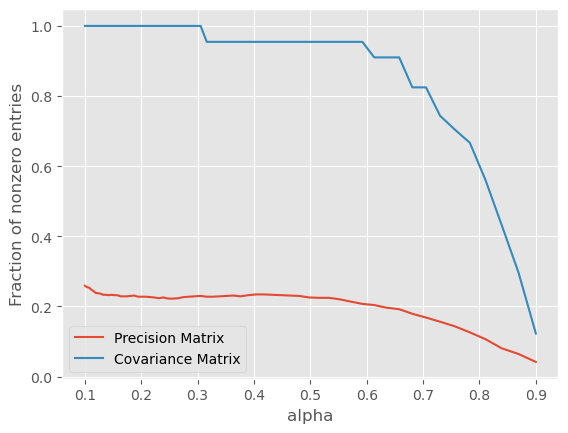

In [199]:
plt.plot(alphas,precision_sparsities,label="Precision Matrix")
plt.plot(alphas,covariance_sparsities,label="Covariance Matrix")
plt.xlabel("alpha")
plt.ylabel("Fraction of nonzero entries")
plt.legend()
# y axis is how many things have been set to 0 
# small alpha means more nonzero entries, because not eagerly dropping stuff 
# increasing alpha is making more things 0 because it;s eagerly dropping stuff 
#any value of alpha will be .5, not sensitive to choice of alpha within this more or less range 
# set alpha as low as I can get away with (.01 or .02) preserves more signal 


- small alpha = less sparse 

In [200]:
model.get_params()

{'alpha': 0.9,
 'assume_centered': True,
 'covariance': None,
 'enet_tol': 0.0001,
 'eps': 2.220446049250313e-16,
 'max_iter': 1000,
 'mode': 'cd',
 'tol': 0.01,
 'verbose': False}

/home/mlauber/miniconda3/envs/mci_mri_graph/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -2.964e-02
  warnings.warn(


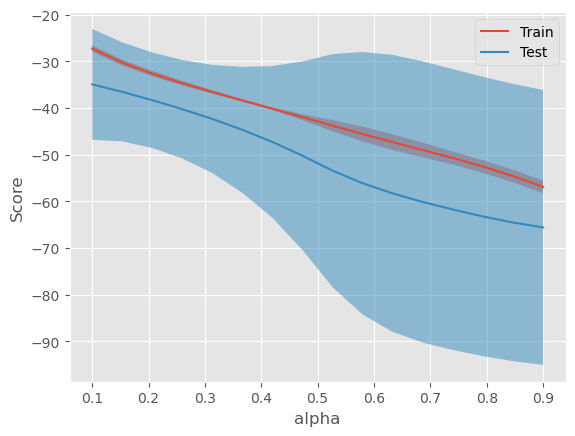

In [201]:
#I think this is a training curve? 
# reprents the model performance 
model = GraphicalLasso(max_iter=1000, tol=1e-2,mode='cd', assume_centered=True)


ValidationCurveDisplay.from_estimator(estimator=model,
                                      X=adni_cent_low_norm,
                                      y=None,
                                      cv=10,
                                      param_name='alpha',
                                      param_range=np.linspace(0.1,0.9,16),
                                      n_jobs=-1
                                     )

- not overfitting, train and test scores similar across all alphas
- higher alpha slightly wors score
- no special point 
- how to select alpha? 

C. As expected, with increasing $\alpha$ our sparse approximation of the covariance matrix gets worse. 

- There's an inflection point around $\alpha = 0.5$, does it mean anything?
- At $\alpha=0.5$ the covariance matrix is still 90% filled, it might be a good idea to make it much more and then decrease alpha gradually if we cannot see any difference between the two groups.

# II. Train graphical model on bootstrapped sample 
- find score on each num bootstrap sample 

In [221]:
models = []

for bootstrap_sample in tqdm(bootstrap_samples):
    model = GraphicalLasso(alpha=0.9,max_iter=150, tol=1e-3) #if I predefine an alpha it will take less time 
    
    model.fit(bootstrap_sample)
    models.append(model) 

100%|██████████| 100/100 [00:03<00:00, 26.09it/s]


In [222]:
bootstrap_sample.head()

,SUPRAMARGINAL,AMYGDALA,MIDDLETEMPORAL,PARSOPERCULARIS,CAUDALANTERIORCINGULATE,INSULA,MEDIALORBITOFRONTAL,ENTORHINAL,PUTAMEN,PERICALCARINE,ROSTRALANTERIORCINGULATE,PRECUNEUS,THALAMUS,CAUDALMIDDLEFRONTAL,ACCUMBENS_AREA,ISTHMUSCINGULATE,FRONTALPOLE,PARSTRIANGULARIS,ROSTRALMIDDLEFRONTAL,SUPERIORPARIETAL,CAUDATE,LINGUAL,LATERALORBITOFRONTAL,LATERALOCCIPITAL,PARSORBITALIS,VENTRALDC,PRECENTRAL,TEMPORALPOLE,INFERIORPARIETAL,TRANSVERSETEMPORAL,CUNEUS,PALLIDUM,INFERIORTEMPORAL,POSTERIORCINGULATE,SUPERIORTEMPORAL,FUSIFORM,PARACENTRAL,CEREBELLUM_CORTEX,PARAHIPPOCAMPAL,BANKSSTS,POSTCENTRAL,HIPPOCAMPUS,SUPERIORFRONTAL
0,1.585806,-0.310034,0.288587,2.062621,1.059494,0.833502,1.022262,0.597802,2.897424,1.330889,1.114024,0.680501,2.906771,2.325996,0.225941,0.023967,1.264831,2.143969,1.347819,1.960731,2.124820,0.692845,0.520952,1.039616,1.790105,1.663721,3.883116,0.129075,0.712242,0.430449,1.661470,3.747638,0.391404,1.185821,0.284608,0.415627,4.006648,1.111193,-0.09502,0.117920,3.385498,-0.261633,1.858676
1,1.585806,-0.310034,0.288587,2.062621,1.059494,0.833502,1.022262,0.597802,2.897424,1.330889,1.114024,0.680501,2.906771,2.325996,0.225941,0.023967,1.264831,2.143969,1.347819,1.960731,2.124820,0.692845,0.520952,1.039616,1.790105,1.663721,3.883116,0.129075,0.712242,0.430449,1.661470,3.747638,0.391404,1.185821,0.284608,0.415627,4.006648,1.111193,-0.09502,0.117920,3.385498,-0.261633,1.858676
2,-0.217709,0.677422,-0.092770,-0.335390,-0.168695,-0.014396,-0.048800,0.659421,-0.280367,0.742753,0.053578,0.012771,-0.018285,-0.264568,0.001003,0.143803,0.157770,-0.169123,-0.043072,-0.215939,-0.429243,0.304541,0.022963,0.328674,-0.039180,0.503634,-0.427836,-0.126530,-0.057721,0.106010,0.190274,0.294945,-0.087774,-0.202260,-0.233970,-0.119397,-0.206721,-0.582053,0.03244,0.015869,-0.626493,0.752254,-0.452228
3,-0.217709,0.677422,-0.092770,-0.335390,-0.168695,-0.014396,-0.048800,0.659421,-0.280367,0.742753,0.053578,0.012771,-0.018285,-0.264568,0.001003,0.143803,0.157770,-0.169123,-0.043072,-0.215939,-0.429243,0.304541,0.022963,0.328674,-0.039180,0.503634,-0.427836,-0.126530,-0.057721,0.106010,0.190274,0.294945,-0.087774,-0.202260,-0.233970,-0.119397,-0.206721,-0.582053,0.03244,0.015869,-0.626493,0.752254,-0.452228
4,-0.217709,0.677422,-0.092770,-0.335390,-0.168695,-0.014396,-0.048800,0.659421,-0.280367,0.742753,0.053578,0.012771,-0.018285,-0.264568,0.001003,0.143803,0.157770,-0.169123,-0.043072,-0.215939,-0.429243,0.304541,0.022963,0.328674,-0.039180,0.503634,-0.427836,-0.126530,-0.057721,0.106010,0.190274,0.294945,-0.087774,-0.202260,-0.233970,-0.119397,-0.206721,-0.582053,0.03244,0.015869,-0.626493,0.752254,-0.452228


- Training curve? 

## A. Single graphical model visualization
 - This visualization is showing the precision matrix of the last model fitted in the loop, which corresponds to the last bootstrapped sample in the bootstrap_samples list. The graph shows the estimated relationships (connections) between variables based on the precision matrix of that particular bootstrapped sample.
 - The node size in these visualizations is calcuated based on node_degrees which is the connectivity strength of each node in the network (degree centrality)
 - Nodes that are more connected (have more connections appear larger, indicating their importance of centrality to the network)
 - Node color is also based on node degree centrality. Nodes with lower degrees are assigned lighter shaded and nodes with higher degrees are assigned darker shades 
 - So the larger and darker nodes are the ones with the highest degree centrality (most connected)
 - In disease context I can make the argument that these 

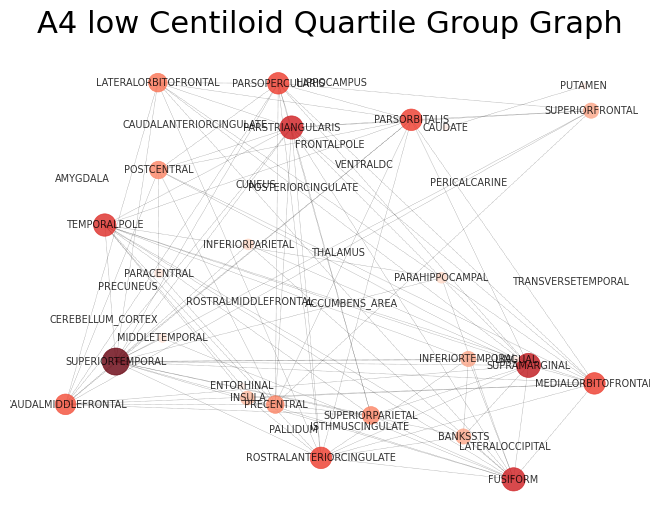

In [223]:
# just for graph visualization, doesn't work for bootstrapped because there's more than one pop graph 
# node size based on connectivity visualization 
# assigns node labels based on the column id 
# this doesn't work because it's the bootstrap sample list 
#It looks like it is working 
precision_matrix_p = model.precision_
np.fill_diagonal(precision_matrix_p, 0) #removes self connections by replacing the diagnonal of matrix with 0 

G_prog = nx.Graph(precision_matrix_p)
#create a dictionary that maps old node labels to new node labels
node_labels = {i: label for i, label in enumerate(adni_cent_low.columns)}

#relabel the nodes in the graph using the dictionary
G_prog = nx.relabel_nodes(G_prog, node_labels)

# Assuming you already have precision_matrix_np and G_n_prog as in your code
# Calculate the node degrees (connectivity strength)
node_degrees = dict(G_prog.degree())

# Scale the node sizes based on node degrees
node_sizes = [20 * node_degrees[node] for node in G_prog.nodes()]

# Create a colormap for node colors based on node degrees
node_colors = list(node_degrees.values())

# Draw the graph with node sizes and colors
pos = nx.random_layout(G_prog)
nx.draw(
    G_prog,
    pos,
    with_labels=True,
    font_size=7,
    style="dotted",
    node_color=node_colors,
    cmap=plt.cm.Reds,
    node_size=node_sizes,
    alpha=0.8,
    width=0.3,
)

plt.title("A4 low Centiloid Quartile Group Graph", fontsize=22)
plt.show()

# the random layout changes, to have the same one run the layout finctiopn first, choose what I want and then try it later 
# circular one might be good or spectral (bc it uses info on the degree of each node aware of hubs)
# since these are random seed rnadom generator to generate same layout 
# generate positions once and then pass same poisition dictioary 
# network x is generating citionary of 2d positins to draw function 
# draw in circle (then spot patterns that way)



#there no single regions where it is the source, the changes in different regions are dependent

In [216]:
#among highly connected nodes - see if the connections are themselves connected 
# take node, look at it's connections 
# star structure with one node where others fan out from it 
# look for single hub with 
# create subgraph of amplifying nodes - and then look at the number of edges in the sub graph must be low 


## B. Average graphical model visualization for each group 
- I want a visualization that represents the average or consensus relationships across all bootstrapped models, you would need to compute some kind of aggregation or summary of the precision matrices from all the models in the models list.
- could be done by averaging the precision matrices element-wise or by using a statistical measure to combine them.
- could potentially combine the precision matrices from all the models and then create a graph based on this combined precision matrix. 

  6%|▌         | 6/100 [00:00<00:03, 24.59it/s]/home/mlauber/miniconda3/envs/mci_mri_graph/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning:

graphical_lasso: did not converge after 150 iteration: dual gap: 2.058e-03

100%|██████████| 100/100 [00:04<00:00, 21.41it/s]


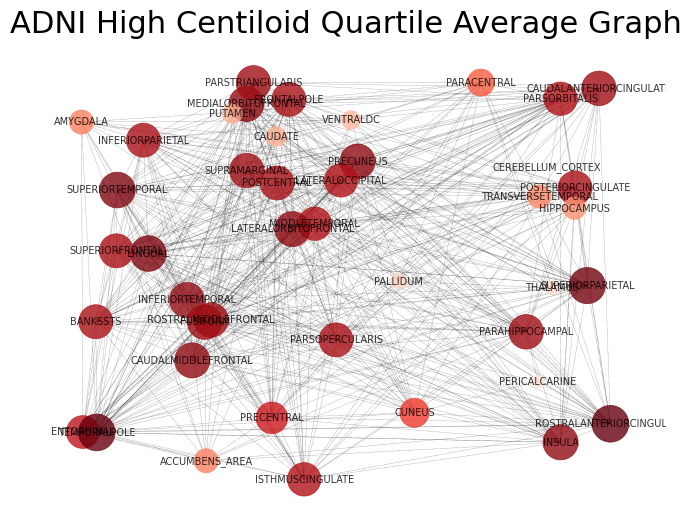

In [217]:
# Initialize an empty precision matrix accumulator
num_variables = bootstrap_samples[0].shape[1]
precision_matrix_accumulator = np.zeros((num_variables, num_variables))

# Loop through bootstrapped samples
for bootstrap_sample in tqdm(bootstrap_samples):
    model = GraphicalLasso(alpha=0.7, max_iter=150, tol=1e-3)
    model.fit(bootstrap_sample)
    # Add the precision matrix from the model to the accumulator element-wise
    precision_matrix_accumulator += model.precision_

# Normalize the accumulator by dividing by the number of bootstrapped samples
precision_matrix_avg = precision_matrix_accumulator / len(bootstrap_samples)

# Remove self-connections
np.fill_diagonal(precision_matrix_avg, 0)

# Create a graph based on the average precision matrix
# G_avg is an avg representation of the graphical structures from running the graphical model on 100 bootstrap samples 
#each indv 
G_avg = nx.Graph(precision_matrix_avg)

# Relabel nodes as in your original code
node_labels = {i: label for i, label in enumerate(adni_cent_high.columns)}
G_avg = nx.relabel_nodes(G_avg, node_labels)

# Calculate node degrees (connectivity strength)
node_degrees = dict(G_avg.degree())

# Scale node sizes based on node degrees
node_sizes = [20 * node_degrees[node] for node in G_avg.nodes()]

# Create a colormap for node colors based on node degrees
node_colors = list(node_degrees.values())

# Draw the graph with node sizes and colors
pos = nx.random_layout(G_avg)
nx.draw(
    G_avg,
    pos,
    with_labels=True,
    font_size=7,
    style="dotted",
    node_color=node_colors,
    cmap=plt.cm.Reds,
    node_size=node_sizes,
    alpha=0.8,
    width=0.3,
)
#(Average of 100 Models from 100 Bootstrap Samples)
plt.title("ADNI High Centiloid Quartile Average Graph", fontsize=22)
plt.show()



  7%|▋         | 7/100 [00:00<00:04, 18.74it/s]/home/mlauber/miniconda3/envs/mci_mri_graph/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning:

graphical_lasso: did not converge after 150 iteration: dual gap: 2.058e-03

100%|██████████| 100/100 [00:04<00:00, 21.51it/s]


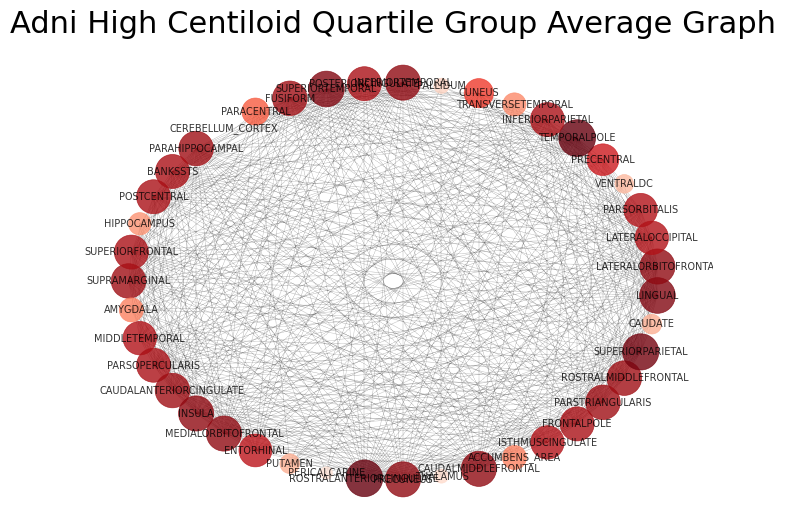

In [218]:
#trying spiral layout, it seems like they are in order of last is outermost on the spiral and so on 
# Initialize an empty precision matrix accumulator
num_variables = bootstrap_samples[0].shape[1]
precision_matrix_accumulator = np.zeros((num_variables, num_variables))

# Loop through bootstrapped samples
for bootstrap_sample in tqdm(bootstrap_samples):
    model = GraphicalLasso(alpha=0.7, max_iter=150, tol=1e-3)
    model.fit(bootstrap_sample)
    # Add the precision matrix from the model to the accumulator element-wise
    precision_matrix_accumulator += model.precision_

# Normalize the accumulator by dividing by the number of bootstrapped samples
precision_matrix_avg = precision_matrix_accumulator / len(bootstrap_samples)

# Remove self-connections
np.fill_diagonal(precision_matrix_avg, 0)

# Create a graph based on the average precision matrix
# G_avg is an avg representation of the graphical structures from running the graphical model on 100 bootstrap samples 
#each indv 
G_avg = nx.Graph(precision_matrix_avg)

# Relabel nodes as in your original code
node_labels = {i: label for i, label in enumerate(adni_cent_high.columns)}
G_avg = nx.relabel_nodes(G_avg, node_labels)

# Calculate node degrees (connectivity strength)
node_degrees = dict(G_avg.degree())

# Scale node sizes based on node degrees
node_sizes = [20 * node_degrees[node] for node in G_avg.nodes()]

# Create a colormap for node colors based on node degrees
node_colors = list(node_degrees.values())
#nodes with lower degrees are assigned lighter shaded and nodes with higher degrees are assigned darker shades 

# Draw the graph with fixed node positions using the "spring_layout" algorithm
pos = nx.shell_layout(G_avg)  # You can specify a seed for reproducibility
seed_value = 0
nx.draw(
    G_avg,
    pos,
    with_labels=True,
    font_size=7,
    style="dotted",
    node_color=node_colors,
    cmap=plt.cm.Reds,
    node_size=node_sizes,
    alpha=0.8,
    width=0.3,
)
#(Average of 100 Models from 100 Bootstrap Samples)
plt.title("Adni High Centiloid Quartile Group Average Graph", fontsize=22)
plt.show()

- plot average precision matrix for all bootsrapped models

instead of the way I am doing below: 
- take list of the models, build an array with true indices (nump array with 3 axes, 2 axes are prec mat nad third is the stack, compute std along the 3rd axis)
- put all of them in a list and call numpy array in the list 

- avg across axis = 2 (2 because axis indexing starts at 0) 
- matrix.mean(axis=2)
- or np.mean(matrix,axis=2)
#output is matrix thathas same shape as original precision matrix but output is averaged across all of the precision matrices in stack 

- or do std. 
- mean is avg of all and std is something to compare it to 
- so calc std to put .005 in perspective, so if the std very small things are ok (if the std is bigger than the .005 then maybe not great)

Range of values in the average precision matrix: [-0.12003167956542471, 0.0]


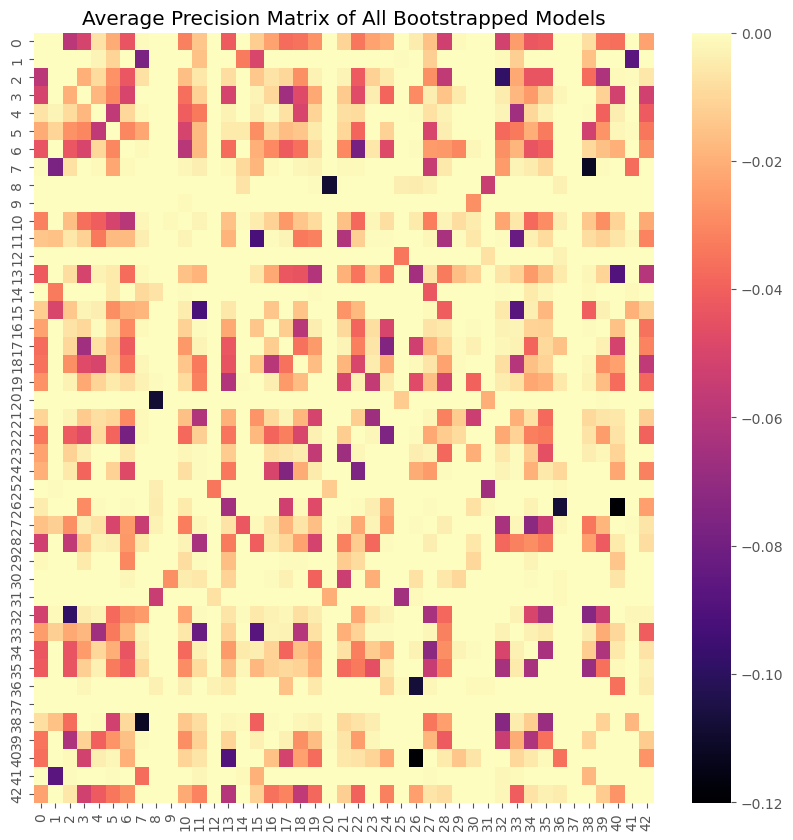

In [208]:
#instad of this: 
#take list of the models, build an array with true indices (nump array with 3 axes, 2 axes are prec mat nad third is the stack, compute std along the 3rd axis)
#put all of them in a list and call numpy array in the list 

#heatmap of precision matrix (precision matrix is the inverse of the covariance matrix)
#ionitialize an empty precision matrix accumulator
num_variables = models[0].precision_.shape[0]
precision_matrix_accumulator = np.zeros((num_variables, num_variables))

# loop through models and accumulate precision matrices
for model in models:
    precision_matrix_accumulator += model.precision_

# normalize the accumulator by dividing by the number of models
average_precision_matrix = precision_matrix_accumulator / len(models)

# set the diagonal to zero
np.fill_diagonal(average_precision_matrix, 0)

# calculate the range of values in the average precision matrix, use this to set plotting threshold
min_value = np.min(average_precision_matrix)
max_value = np.max(average_precision_matrix)
print(f"Range of values in the average precision matrix: [{min_value}, {max_value}]")

# Create a heatmap of the average precision matrix_
plt.figure(figsize=(10, 10))
sns.heatmap(average_precision_matrix, cmap='magma', annot=False)  # assuming values range from -1 to 0.25
plt.title('Average Precision Matrix of All Bootstrapped Models')
plt.show()

#interpreting precision and cov matrix: 
#if entry is 0 conditionall ind 
# calc the covariance matrix oinstead
#model I am using estimates precision matrix and it makes it sparse
#cov mat is not nessisraily sparse even if precision is sparse 
#so estimate the correlation coeffient all of those are in cov mat (know that these numbers are  big or small comapred to 1 so it gives refernce)



#advantages of precision matrix - for looking if things are indepedent or not becuase (if this entry is 0 then they are ind, if non zero they are dep in some way)
#for undertsanding meaning of values - clearer to visualize covairance matrix 


Range of values in the average covariance matrix: [0.0, 1.0150003387343427]


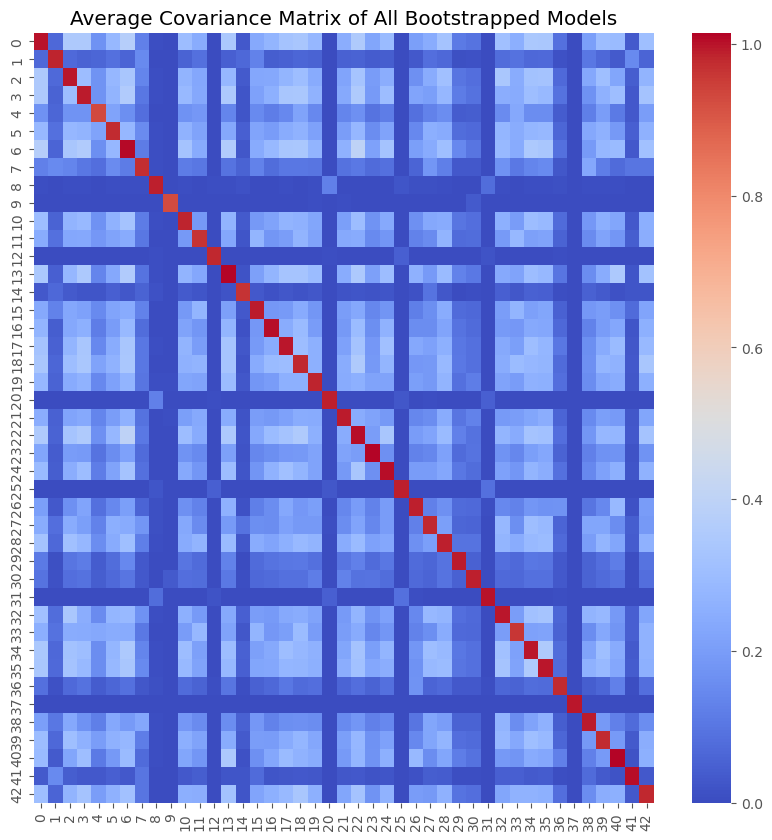

In [209]:
#covariance matrix 
#interpreting precision and cov matrix: 
#for undertsanding meaning of values - clearer to visualize covairance matrix 
#if entry is 0 conditionall ind 
# calc the covariance matrix oinstead
#model I am using estimates precision matrix and it makes it sparse
#cov mat is not nessisraily sparse even if precision is sparse 
#so estimate the correlation coeffient all of those are in cov mat (know that these numbers are  big or small comapred to 1 so it gives refernce)
# Initialize an empty covariance matrix accumulator
num_variables = models[0].covariance_.shape[0]
covariance_matrix_accumulator = np.zeros((num_variables, num_variables))

# Loop through models and accumulate covariance matrices
for model in models:
    covariance_matrix_accumulator += model.covariance_

# Normalize the accumulator by dividing by the number of models
average_covariance_matrix = covariance_matrix_accumulator / len(models)

# Calculate the range of values in the average covariance matrix, use this to set the plotting threshold
min_value = np.min(average_covariance_matrix)
max_value = np.max(average_covariance_matrix)
print(f"Range of values in the average covariance matrix: [{min_value}, {max_value}]")

# Create a heatmap of the average covariance matrix
plt.figure(figsize=(10, 10))
sns.heatmap(average_covariance_matrix, cmap='coolwarm', annot=False)  # Assuming values range from -1 to 1
plt.title('Average Covariance Matrix of All Bootstrapped Models')
plt.show()

#it's ok if the max is 1.009, it could be numerical precision issues and can effectively be treated as 1 

# III. Calculate Whole Graph Metrics 
- These are the metrics calculated for each of the 100 graphical models run on each of the 100 boostrapped samples 

In [210]:
#calc metrics of whole graphs individually 
# terating through each bootsrap sample model, calculating the graph metrics, and then storing the metrics for eahc model in a dataframe 
metrics_data = []
#to get variance, 

#keep track of index with enumerate 
for model_num, model in enumerate(models,start=1):
    precision_matrix_p = model.precision_
    np.fill_diagonal(precision_matrix_p, 0) #removes self connections by replacing the diagnonal of matrix with 0 
    G_prog = nx.Graph(precision_matrix_p)
    node_labels = {i: label for i, label in enumerate(adni_cent_high_norm.columns)}
    #relabel the nodes in the graph using the dictionary
    G_prog = nx.relabel_nodes(G_prog, node_labels)
    #now calculate the metrics and store them 
    gpe = nx.global_efficiency(G_prog) 
    clustering_coefficient = nx.average_clustering(G_prog)
    density = nx.density(G_prog)
    # eigen_cen = nx.eigenvector_centrality(G_prog)
    ass_coeff = nx.degree_assortativity_coefficient(G_prog)

#see how these deal in cases of isolated nodes etc 

    #create dictionary for current models data 
    metrics_dic = {
        'model_num': model_num,
        'gpe': gpe,
        'clus_coeff':clustering_coefficient,
        'density': density,
        'ass_coeff': ass_coeff
    }
    metrics_data.append(metrics_dic)


#turn the list of dictionaries with each model info into a df
metrics_data = pd.DataFrame(metrics_data)
# print(metrics_data.dtypes)
print(metrics_data.head())

#see why these functions are not running correctly

/home/mlauber/miniconda3/envs/mci_mri_graph/lib/python3.10/site-packages/networkx/algorithms/assortativity/correlation.py:298: RuntimeWarning:

invalid value encountered in scalar divide

/home/mlauber/miniconda3/envs/mci_mri_graph/lib/python3.10/site-packages/networkx/algorithms/assortativity/mixing.py:207: RuntimeWarning:

invalid value encountered in divide



   model_num       gpe  clus_coeff   density  ass_coeff
0          1  0.316537    0.427466  0.151717  -0.169143
1          2  0.546696    0.618509  0.326689   0.230734
2          3  0.587984    0.652249  0.338870   0.279699
3          4  0.003322    0.000000  0.003322        NaN
4          5  0.052418    0.166814  0.029900  -0.265699


- I'm getting these errors: 
- RuntimeWarning: invalid value encountered in divide
- invalid value encountered in scalar divide
- could potentially be it's trying to divide by zero or very small number
- could be because the graph assostativity is not present in graph (nodes are not strongly connected to similar nodes)


In [211]:
#print(metrics_data)
#calc variance for each metric (which is col for each) like for mean 
#plot the variance for each metric/col across diff num samples (training curve)
# sklearn has training curve display 
# do it on estimator (graph lasso cv and training set) but do it on pop_ggm_code without bootstrap (good to have on poster)
# on bootstrapped data SSE ()

In [212]:
#instead of calcing mean just calc from data instead 
#add col where the p val is greater than .05

# Initialize lists or a DataFrame to store your results
cols = []
p_values = []
t_stats = []

for col in metrics_data.columns:  
    if col != 'model_num':
    # Get data for this brain region from both datasets
        progs_data = metrics_data[col]
        stab_data = stab_metrics_data[col]
        
        # Perform t-test
        t_stat, p_val = stats.ttest_ind(progs_data, stab_data, equal_var=False)  # Assuming variance might not be equal
        
        # Store results
        cols.append(col)
        t_stats.append(t_stat)
        p_values.append(p_val)

    # Combine results into a DataFrame for easy viewing and further analysis
    results_df = pd.DataFrame({
        'Brain Region': cols,
        'T-Statistic': t_stats,
        'P-Value': p_values
})

# Adding the Significant column based on the P-Value
results_df['Significant'] = results_df['P-Value'] < 0.05

# Display or save the results
print(results_df)
# Optionally save to a CSV file
# results_df.to_csv('t_test_results.csv', index=False)

#the resulting negative t stats mean the progs have lower volume than the stab which is good 
# results_df.to_csv('/data2/MRI_PET_DATA/graph/csvs/bootstrap_models_and_metrics/50_bootstrap_models_ttest.csv')


NameError: name 'stab_metrics_data' is not defined

# Interpreting Results 

In [ ]:
# Check that all dataframes have the same datatypes for each column
datatypes = nacc_bootstrap_samples[0].dtypes  # Get datatypes of the first dataframe
same_datatypes = all((df.dtypes == datatypes).all() for df in nacc_bootstrap_samples)

print(f'All dataframes have the same datatypes for each column: {same_datatypes}')


All dataframes have the same datatypes for each column: True


In [ ]:


# Assuming nacc_bootstrap_samples is your list of DataFrames
for i, df in enumerate(nacc_bootstrap_samples):
    if df.isnull().values.any():
        print(f'NaN values found in DataFrame at index {i}')
    else:
        print(f'No NaN values found in DataFrame at index {i}')

# If you want to see the total count of NaN values across all DataFrames:
total_nan_count = sum(df.isnull().sum().sum() for df in nacc_bootstrap_samples)
print(f'Total NaN count across all DataFrames: {total_nan_count}')


No NaN values found in DataFrame at index 0
No NaN values found in DataFrame at index 1
No NaN values found in DataFrame at index 2
No NaN values found in DataFrame at index 3
No NaN values found in DataFrame at index 4
No NaN values found in DataFrame at index 5
No NaN values found in DataFrame at index 6
No NaN values found in DataFrame at index 7
No NaN values found in DataFrame at index 8
No NaN values found in DataFrame at index 9
No NaN values found in DataFrame at index 10
No NaN values found in DataFrame at index 11
No NaN values found in DataFrame at index 12
No NaN values found in DataFrame at index 13
No NaN values found in DataFrame at index 14
No NaN values found in DataFrame at index 15
No NaN values found in DataFrame at index 16
No NaN values found in DataFrame at index 17
No NaN values found in DataFrame at index 18
No NaN values found in DataFrame at index 19
No NaN values found in DataFrame at index 20
No NaN values found in DataFrame at index 21
No NaN values found 

In [ ]:
import pandas as pd
import numpy as np

# Assuming nacc_bootstrap_samples is your list of DataFrames
for i, df in enumerate(nacc_bootstrap_samples):
    if np.isinf(df).values.any():
        print(f'Infinite values found in DataFrame at index {i}')
    else:
        print(f'No infinite values found in DataFrame at index {i}')

# If you want to see the total count of infinite values across all DataFrames:
total_inf_count = sum(np.isinf(df).sum().sum() for df in nacc_bootstrap_samples)
print(f'Total infinite count across all DataFrames: {total_inf_count}')


No infinite values found in DataFrame at index 0
No infinite values found in DataFrame at index 1
No infinite values found in DataFrame at index 2
No infinite values found in DataFrame at index 3
No infinite values found in DataFrame at index 4
No infinite values found in DataFrame at index 5
No infinite values found in DataFrame at index 6
No infinite values found in DataFrame at index 7
No infinite values found in DataFrame at index 8
No infinite values found in DataFrame at index 9
No infinite values found in DataFrame at index 10
No infinite values found in DataFrame at index 11
No infinite values found in DataFrame at index 12
No infinite values found in DataFrame at index 13
No infinite values found in DataFrame at index 14
No infinite values found in DataFrame at index 15
No infinite values found in DataFrame at index 16
No infinite values found in DataFrame at index 17
No infinite values found in DataFrame at index 18
No infinite values found in DataFrame at index 19
No infinit

In [ ]:
# checking if there is a nan value in the data 
# for index, value in enumerate(nacc_bootstrap_samples):
#     if math.isnan(value):
#         print(f'NaN found at index {index}')

# IV. T Test Between Groups? Some sort of stat sig test

In [ ]:
#nacc t test 
#instead of calcing mean just calc from data instead 
#add col where the p val is greater than .05

# Initialize lists or a DataFrame to store your results
cols = []
p_values = []
t_stats = []

# Note: The dataframe should be adni_gmv_progs, not adni_gmv_prog
for col in nacc_metrics_data.columns:  
    if col != 'model_num':
    # Get data for this brain region from both datasets
        nacc_progs_data = nacc_metrics_data[col]
        nacc_stab_data = nacc_stab_metrics_data[col]
        
        # Perform t-test
        t_stat, p_val = stats.ttest_ind(nacc_progs_data, nacc_stab_data, equal_var=False)  # Assuming variance might not be equal
        
        # Store results
        cols.append(col)
        t_stats.append(t_stat)
        p_values.append(p_val)

    # Combine results into a DataFrame for easy viewing and further analysis
    nacc_results_df = pd.DataFrame({
        'Brain Region': cols,
        'T-Statistic': t_stats,
        'P-Value': p_values
})

# Adding the Significant column based on the P-Value
nacc_results_df['Significant'] = nacc_results_df['P-Value'] < 0.05

# Display or save the results
print("Nacc t test results between nacc prog and nacc stab")
print(nacc_results_df)
# Optionally save to a CSV file
# results_df.to_csv('t_test_results.csv', index=False)

#The results previously have been saved so I could even just load them 
#the resulting negative t stats mean the progs have lower volume than the stab which is good 
nacc_results_df.to_csv('/data2/MRI_PET_DATA/graph/csvs/bootstrap_models_and_metrics/50_bootstrap_models_ttest_nacc.csv')


Nacc t test results between nacc prog and nacc stab
  Brain Region  T-Statistic       P-Value  Significant
0          gpe   -11.130935  2.870134e-19         True
1   clus_coeff    -2.696797  7.854546e-03         True
2      density    -9.305936  2.348927e-15         True
3    ass_coeff    -8.811971  8.721287e-15         True


In [ ]:
print("Adni t test results between adni prog and adni stab")
print(results_df)
#andi and nacc results are the exact same so need to figure out why they are not 

Adni t test results between adni prog and adni stab
  Brain Region  T-Statistic       P-Value  Significant
0          gpe    -6.349198  3.268807e-09         True
1   clus_coeff   -22.606128  9.647343e-57         True
2      density   -27.292662  1.028930e-63         True
3    ass_coeff    -5.030910  1.270020e-06         True
